In [116]:
import json
import math
import base64
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from celluloid import Camera
from IPython.display import Image
from IPython.display import HTML

index = 0
asinToIndex = {}
scoreMatrix = []
booksAsin = []
bookReviewYearly = {}
yearlyReviewCount = {}
minYear = 3000
maxYear = 0
chunks = pd.read_json(
    '../Dataset/Books.json', lines=True, chunksize=500000, 
    typ="frame", orient="records", dtype={"asin": str, "overall": int, "unixReviewTime": int}
)

nbChunks = 20
for chunk in chunks:
    for _, item in chunk.iterrows():
        asin = item["asin"]
        rate = item["overall"]
        reviewTime = item["unixReviewTime"]
        reviewDate = datetime.utcfromtimestamp(reviewTime)
        bookReviewElement = bookReviewYearly.setdefault(reviewDate.year, {}).setdefault(reviewDate.month, {}).setdefault(asin, [0,0,0,0,0])
        bookReviewYearly[reviewDate.year][reviewDate.month][asin][rate-1] += 1
        yearlyReviewCount.setdefault(reviewDate.year, 0)
        yearlyReviewCount[reviewDate.year] += 1
        maxYear = max(maxYear, reviewDate.year)
        minYear = min(minYear, reviewDate.year)

        if (asin not in asinToIndex):
            scoreMatrix.append([0,0,0,0,0])
            booksAsin.append(asin)
            asinToIndex[asin] = index
            index += 1

        row = asinToIndex[asin]
        scoreMatrix[row][rate-1] += 1
    nbChunks -= 1
    if (nbChunks == 0):
        break # comment to load everything

scoreMatrix = np.array(scoreMatrix)
pdScoreMat = pd.DataFrame(
    data=scoreMatrix,
    index=booksAsin,
    columns=[f"{i} ⭐" for i in range(1, 6)]
)
pdScoreMat

1 ⭐  2 ⭐  3 ⭐  4 ⭐  5 ⭐
000100039X    6    4    8   15  173
0001055178    0    4    2   10    2
0001473123    1    0    0    2   13
0001473727    0    0    0    0    7
0001473905    0    0    1    0    5
...         ...  ...  ...  ...  ...
B00LZFHL7Y    0    0    1    2   13
B00LZKMXBI    0    1    4   14  141
B00M029T4O    0    0    0    1   12
B00M0RE7CS    0    0    0    1   29
B00M13FNSS    0    0    0    1    6

[367982 rows x 5 columns]

In [117]:
def getAvgRating(scoreMatrix):
    nbRating = np.sum(scoreMatrix, axis=1)
    avgRatings = (np.average(scoreMatrix, axis=1, weights=[1,2,3,4,5]) * 15) / nbRating
    return nbRating, avgRatings

nbRating, avgRatings = getAvgRating(scoreMatrix)
print(f"Nb rating = {nbRating}")
print(f"Average rating = {avgRatings}")

def getRatingsStd(scoreMatrix):
    stdRatings = np.std(scoreMatrix, axis=0)
    return stdRatings

stdRatings = getRatingsStd(scoreMatrix)
print(f"Rating's standard deviation = {stdRatings}")

def getMinMaxRating(scoreMatrix):
    maxRating = np.max(scoreMatrix, axis=0)
    minRating = np.min(scoreMatrix, axis=0)
    return minRating, maxRating

minRating, maxRating = getMinMaxRating(scoreMatrix)
print(f"Max rating = {maxRating}, Min Rating = {minRating}")

def getRatingsQuantile(scoreMatrix):
    ratingQ1 = np.quantile(scoreMatrix, 0.25, axis=0)
    ratingQ2 = np.quantile(scoreMatrix, 0.5, axis=0)
    ratingQ3 = np.quantile(scoreMatrix, 0.75, axis=0)
    return ratingQ1, ratingQ2, ratingQ3

ratingQ1, ratingQ2, ratingQ3 = getRatingsQuantile(scoreMatrix)
print(f"Rating quantile : Q1 = {ratingQ1}, Q2 = {ratingQ2}, Q3 = {ratingQ3}")

# Books sorted by average score
def getTop3Bottom3AndQ1Books(scoreMatrix):
    sortedIndicies = np.flip(np.argsort(avgRatings)) # Ascending order
    top3Books = [booksAsin[i] for i in sortedIndicies[0:3]]
    bottom3Books = [booksAsin[i] for i in sortedIndicies[-1:-4:-1]]
    q1BestBooksAsins = [booksAsin[i] for i in sortedIndicies[0:math.ceil(len(sortedIndicies) * 0.25)]]
    return top3Books, bottom3Books, q1BestBooksAsins

top3Books, bottom3Books, q1BestBooksAsins = getTop3Bottom3AndQ1Books(scoreMatrix)
print(f"Top 3 books : {top3Books}, Bottom 3 books : {bottom3Books}")
print(f"First Quantile of Best books : {q1BestBooksAsins}")

Nb rating = [206  18  16 ...  13  30   7]
Average rating = [4.67475728 3.55555556 4.625      ... 4.92307692 4.96666667 4.85714286]
Rating's standard deviation = [ 4.80940217  4.13915117  7.78034967 16.19318042 39.73618729]
Max rating = [1565  640 1209 2065 4839], Min Rating = [0 0 0 0 0]
Rating quantile : Q1 = [0. 0. 0. 1. 4.], Q2 = [0. 0. 1. 3. 6.], Q3 = [ 1.  1.  3.  6. 12.]
Top 3 books : ['B00J7X9BKG', 'B00KMXDQ1A', '0835608794'], Bottom 3 books : ['1419643797', 'B008L2KL08', 'B008KXP65S']
First Quantile of Best books : ['B00J7X9BKG', 'B00KMXDQ1A', '0835608794', 'B008AD15P8', '1481152092', 'B0055IIBT4', '1493556193', '0373872232', 'B00I8VW4NO', '1433523043', '0764112589', 'B006RW57TY', '0446404055', 'B00H17FPHI', '0446402249', 'B006RV0B4G', '0879306394', '0847830039', '0446401692', '159643368X', '0446400300', '0847830942', '1449916937', 'B00C1N4BTA', '1596435291', '0446391964', '144990467X', '1596435399', '0847829537', 'B00H12XIBI', 'B00C1O6EHQ', '1449948243', '0446525839', '1449961

In [118]:
plt.figure(figsize=(8, 6), dpi=80)
plt.boxplot(scoreMatrix, showfliers=False)
plt.show()

Eigenvector : [3.8484473  0.73351121 0.27006033 0.09641518 0.05157957]
Eigenvalues : [[ 0.38290409  0.69853594  0.49585562 -0.34299185 -0.04376962]
 [ 0.46836074  0.32523524 -0.32791971  0.66635992  0.35113157]
 [ 0.48530595 -0.05635775 -0.48116346 -0.17856159 -0.70561989]
 [ 0.46901486 -0.37564442 -0.14499092 -0.52563855  0.58446392]
 [ 0.42252321 -0.51184436  0.62773818  0.36075049 -0.18786522]]
Seperation percentages of PCs : [76.96873676934189, 14.670184329181367, 5.401191891302892, 1.9282983547386168, 1.0315886554352336]
Confidence number (C) = 6.0, Arthimetic average of all rating (m) = 4.261260090435146
Bayes average rating = [4.66305453 3.73198169 4.52579821 ... 4.71408213 4.8490989  4.58212004]


Classes count : {'Bad': 1321, 'Average': 68143, 'Good': 298518}


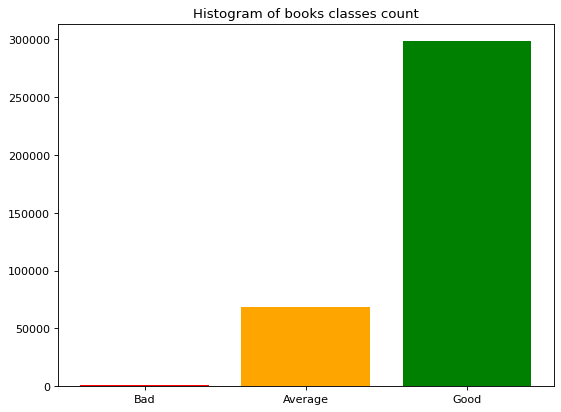

In [119]:
# Normalise score matrix
def normalizeData(scoreMatrix):
    normalizedScoreMatrix = (scoreMatrix - np.mean(scoreMatrix, axis = 0)) / np.std(scoreMatrix, axis = 0)
    return normalizedScoreMatrix

# Calculating PCA
def PCA(scoreMatrix):
    # Normalise score matrix
    normalizedScoreMatrix = normalizeData(scoreMatrix)
    # Calculate covariance
    scoreMatrixCov = np.cov(normalizedScoreMatrix, rowvar = False) # rowvar allows us to transpose data!
    # Calculate eigen-values and eigen-vectors
    eigenValues, eigenVectors = np.linalg.eig(scoreMatrixCov)
    # Variance of each Principal Component (PC)
    idx = np.argsort(eigenValues)[::-1]
    evecs = eigenVectors[:,idx]
    evals = eigenValues[idx]
    evalsVar = [ (eval/sum(evals)) * 100 for eval in evals ]
    #  PCA calculation
    projectionMatrix = np.transpose(np.transpose(evecs)[:][:2])
    projectedPcaMatrix = np.dot(normalizedScoreMatrix, projectionMatrix)
    return eigenValues, eigenVectors, evalsVar, projectionMatrix, projectedPcaMatrix

eigenValues, eigenVectors, evalsVar, projectionMatrix, projectedPcaMatrix = PCA(scoreMatrix)
print(f"Eigenvector : {eigenValues}")
print(f"Eigenvalues : {eigenVectors}")
print(f"Seperation percentages of PCs : {evalsVar}")

# Calculate better average metric to classify books
def bayesAverage(avgRatings, nbRating, C, m):
    bayesAvgRatings = (nbRating * avgRatings + m * C) / (nbRating + C)
    return bayesAvgRatings

C = np.quantile(nbRating, 0.25)
m = np.mean(avgRatings)
bayesAvgRatings = bayesAverage(avgRatings, nbRating, C, m)
print(f"Confidence number (C) = {C}, Arthimetic average of all rating (m) = {m}")
print(f"Bayes average rating = {bayesAvgRatings}")

classifierFunc = np.vectorize(lambda score: 0 if (score < 3) else 2 if (score > 4) else 1)
classes = ['Bad', 'Average', 'Good']
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)

def plotPCAHelper(projectedPcaMatrix, bayesAvgRatings, extraText=""):
    x, y = np.transpose(projectedPcaMatrix)
    booksClasses = classifierFunc(bayesAvgRatings)
    scatter = plt.scatter(x, y, c=booksClasses, cmap=colors, s=2)
    plt.legend(handles=scatter.legend_elements(num=3)[0], labels=classes)
    plt.title(f"Scatter plot of different books in the PCA space {extraText}")
    return x, y, booksClasses

def plotPCA(projectedPcaMatrix, bayesAvgRatings, extraText="", show=True, plotCenters=True):
    if (show):
        plt.figure(figsize=(8, 6), dpi=80)
    plt.xlabel(f"PC1 - {math.floor(evalsVar[0])}%")
    plt.ylabel(f"PC2 - {math.floor(evalsVar[1])}%")
    plt.grid()
    x, y, booksClasses = plotPCAHelper(projectedPcaMatrix, bayesAvgRatings, extraText)
    if (plotCenters):
        clusterCentersX = [np.mean(x[booksClasses == i]) for i in range(0,3)]
        clusterCentersY = [np.mean(y[booksClasses == i]) for i in range(0,3)]
        clusterCentersX.append(clusterCentersX[0])
        clusterCentersY.append(clusterCentersY[0])
        plt.plot(clusterCentersX, clusterCentersY, zorder=2, c="black")
        plt.scatter(clusterCentersX, clusterCentersY, c="black", s=10)
    if (show):
        plt.show()
    return booksClasses

booksClasses = plotPCA(projectedPcaMatrix, bayesAvgRatings)
plt.figure(figsize=(8, 6), dpi=80)
rateClasses, classFrequency = np.unique(booksClasses, return_counts=True)
print(f"Classes count : {dict(zip([classes[i] for i in rateClasses], classFrequency))}")
plt.bar([classes[i] for i in rateClasses], height=classFrequency, 
    color=[colorsList[i] for i in rateClasses], align="center") 
plt.title("Histogram of books classes count") 
plt.show()

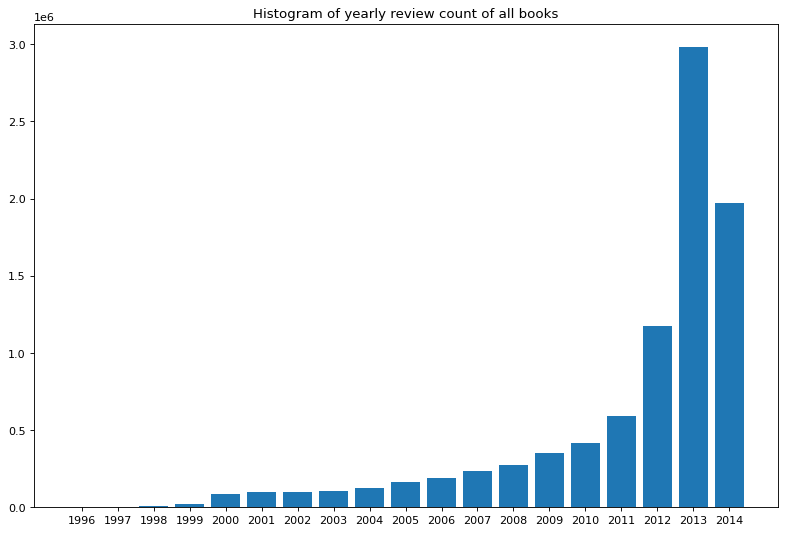

In [120]:
plt.figure(figsize=(12, 8), dpi=80)
yearsSorted = sorted(list(yearlyReviewCount.keys()))
yearXAxis = np.arange(len(yearsSorted))
plt.bar(yearXAxis, [yearlyReviewCount[k] for k in yearsSorted]) 
plt.xticks(yearXAxis, yearsSorted)
plt.title("Histogram of yearly review count of all books") 
plt.show()

In [121]:
def buildScoreMatrix(bookReviewYearly, year, month):
    asins = list(bookReviewYearly[reviewDate.year][reviewDate.month].keys())
    ratings = np.array(list(bookReviewYearly[reviewDate.year][reviewDate.month].values()))
    return asins, ratings

def getYearWithMostReviews(yearlyReviewCount, minYear, maxYear):
    maxReviews = 0
    resYear = minYear
    for y in range(minYear, maxYear+1):
        if (yearlyReviewCount[y] > maxReviews):
            maxReviews = yearlyReviewCount[y]
            resYear = y
    return resYear

yearToStudy = getYearWithMostReviews(yearlyReviewCount, minYear, maxYear)
plotLabels = []
bayesAvgRatinsList = []
projectedRatingsMatrixPCA = []

for m in range(1,13):
    asins, scoreMatrix = buildScoreMatrix(bookReviewYearly, yearToStudy, m)
    print(f"Month {m}/{yearToStudy} : ")
    nbRating, avgRatings = getAvgRating(scoreMatrix)
    # print(f"\tAverage rating = {avgRatings}")

    stdRatings = getRatingsStd(scoreMatrix)
    print(f"\tRating's standard deviation = {stdRatings}")

    minRating, maxRating = getMinMaxRating(scoreMatrix)
    print(f"\tMax rating = {maxRating}, Min Rating = {minRating}")

    ratingQ1, ratingQ2, ratingQ3 = getRatingsQuantile(scoreMatrix)
    print(f"\tRating quantile : Q1 = {ratingQ1}, Q2 = {ratingQ2}, Q3 = {ratingQ3}")

    top3Books, bottom3Books, q1BestBooksAsins = getTop3Bottom3AndQ1Books(scoreMatrix)
    print(f"\tTop 3 books : {top3Books}, Bottom 3 books : {bottom3Books}")
    print(f"\tFirst Quantile of Best books : {q1BestBooksAsins}")

    bayesAvgRatings = bayesAverage(avgRatings, nbRating, C, m)
    print(f"\tBayes average rating = {bayesAvgRatings}")
    scoreMatrixPCA = np.dot(normalizeData(scoreMatrix), projectionMatrix)
    plotLabels.append(f"{m}/{yearToStudy}")
    bayesAvgRatinsList.append(bayesAvgRatings)
    projectedRatingsMatrixPCA.append(scoreMatrixPCA)

fig, ax = plt.subplots(figsize=(8,6), dpi=120)
plt.xlabel(f"PC1 - {math.floor(evalsVar[0])}%")
plt.ylabel(f"PC2 - {math.floor(evalsVar[1])}%")
plt.grid()

def update(i):
    plotPCAHelper(projectedRatingsMatrixPCA[i], bayesAvgRatinsList[i], plotLabels[i])
    x, y = np.transpose(projectedRatingsMatrixPCA[i])
    booksClasses = classifierFunc(bayesAvgRatinsList[i])
    scatter = plt.scatter(x, y, c=booksClasses, cmap=colors, s=2)
    plt.legend(handles=scatter.legend_elements(num=3)[0], labels=classes)

gifPath = "booksReviewEvolution.gif"
anim = animation.FuncAnimation(fig, update, frames=12, interval=25)
anim.save(gifPath, writer="pillow", fps=1)
plt.close()
Image(data=open(gifPath,'rb').read(), format='png')

Month 1/2013 : 
	Rating's standard deviation = [0.3401514  0.42482989 0.77144595 1.53646169 4.29236433]
	Max rating = [ 21  33  48  78 349], Min Rating = [0 0 0 0 0]
	Rating quantile : Q1 = [0. 0. 0. 0. 0.], Q2 = [0. 0. 0. 0. 1.], Q3 = [0. 0. 0. 1. 1.]
	Top 3 books : ['031031884X', '0195178343', '0345361350'], Bottom 3 books : ['0123859360', '0375706976', '0345479734']
	First Quantile of Best books : ['031031884X', '0195178343', '0345361350', '0195173988', '019517383X', '0195173384', '0195172841', '0345362276', '0345362322', '034536239X', '0195172426', '0195171454', '0345362497', '0345362500', '0195170776', '0345362667', '0195170768', '019517075X', '0345363094', '0345363108', '0345363116', '0345363310', '0195170253', '0345363884', '0195170229', '0195169115', '0345365011', '0345361326', '0195174275', '0345360788', '0195176111', '0195177827', '0195177754', '0195177584', '0195176847', '0345356837', '0345356918', '0195176618', '0345357280', '0345357620', '0345358074', '0345358473', '034535